In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from mpl_toolkits.mplot3d import Axes3D
import os
import glob
import madmom
import matplotlib.patches as mpatches
import librosa
import librosa.display

from essentia import *
from essentia.standard import *
from scipy.stats.stats import pearsonr


In [85]:
filename = "/Users/carthach/Music/samples/amen_break/amen_break.mp3"
audio = MonoLoader(filename=filename, sampleRate=44100)()

def extractor(audio):
    # load our audio into an array

    # create the pool and the necessary algorithms
    pool = Pool()
    w = Windowing()
    spec = Spectrum()
    mfcc = MFCC()
    bfcc = BFCC(
        type = 'power',
        weighting = 'linear',
        lowFrequencyBound = 0,
        highFrequencyBound = 8000,
        numberBands = 26,
        numberCoefficients = 13,
        normalize = 'unit_max',
        dctType = 3,
        logType = 'log',
        liftering = 22,
    )
    gfcc = GFCC()
    loudness = Loudness()
    energy = Energy()

    # compute the centroid for all frames in our audio and add it to the pool
    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
        s = spec(w(frame))
        mfcc_bands, mfcc_coeffs = mfcc(s)
        bfcc_bands, bfcc_coeffs = bfcc(s)
        gfcc_bands, gfcc_coeffs = gfcc(s)        
        e = energy(frame)
        
        pool.add('spectrum', s)
        pool.add('mfcc',  mfcc_coeffs)
        pool.add('bfcc',  bfcc_coeffs)
        pool.add('gfcc',  gfcc_coeffs)        
        pool.add('energy',  e)


    # aggregate the results
    aggrpool = PoolAggregator(defaultStats = [ 'mean', 'stdev' ])(pool)

    return pool["spectrum"], pool["mfcc"], pool["bfcc"], pool["gfcc"], pool["energy"]

#Get y and sr
y, sr = audio, 44100

timeInSamples = 10 * 44100
# y = y[0:timeInSamples]
spectrum, mfccs, bfccs, gfccs, energy = extractor(audio)

spectrum = spectrum.T
mfccs = mfccs.T
bfccs = bfccs.T
gfccs = gfccs.T

from scipy.stats.stats import pearsonr

D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


In [86]:
plt.figure(figsize=(10.5, 9))

plt.subplot(221)

plt.title('Waveform')

librosa.display.waveplot(y)

plt.subplot(222)

plt.title('MFCC')

plt.imshow(mfccs, origin="lower", aspect="auto")
plt.colorbar()

plt.xlabel("Frame")
plt.ylabel("Coefficient")

plt.subplot(223)

librosa.display.specshow(D, y_axis='linear', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')

plt.subplot(224)

plt.title('BFCC')

plt.imshow(bfccs, origin="lower", aspect="auto")
plt.colorbar()

plt.xlabel("Frame")
plt.ylabel("Coefficient")

plt.tight_layout()

plt.savefig("wave_spec_mfcc_bfcc.pdf", bbox_inches='tight', dpi=1200)


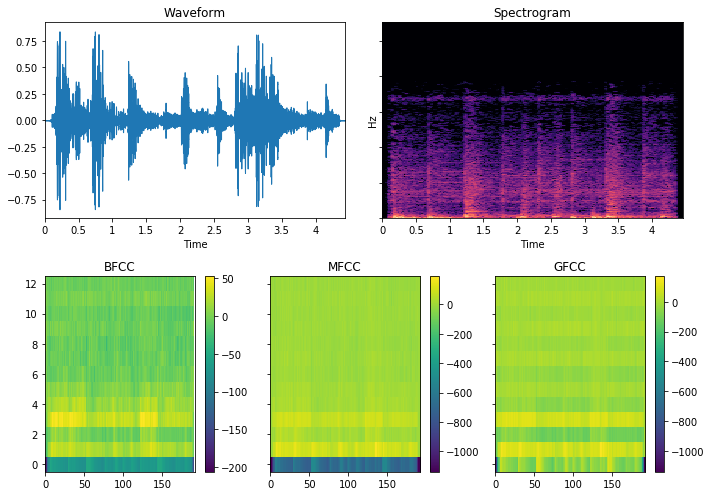

In [112]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(nrows=2, ncols=6)

ax12 = fig.add_subplot(gs[0, :3])
librosa.display.waveplot(y)
plt.title('Waveform')
ax22 = fig.add_subplot(gs[0, 3:])
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
ax11 = fig.add_subplot(gs[1, :2])
plt.imshow(bfccs, origin="lower", aspect="auto")
plt.colorbar()
plt.title('BFCC')
ax21 = fig.add_subplot(gs[1, 2:4])
plt.imshow(mfccs, origin="lower", aspect="auto")
plt.colorbar()
plt.title('MFCC')
ax31 = fig.add_subplot(gs[1, 4:])
plt.imshow(gfccs, origin="lower", aspect="auto")
plt.title('GFCC')
plt.colorbar()

# fig.tight_layout()

# plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax22.get_yticklabels(), visible=False)

plt.setp(ax21.get_yticklabels(), visible=False)
plt.setp(ax31.get_yticklabels(), visible=False)

plt.tight_layout()
plt.savefig("wave_spec_mfcc_bfcc.pdf", bbox_inches='tight', dpi=1200)

plt.show()
